In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-pa

### Data preprocessing

In [2]:
from datetime import datetime

def parse(x):
    return datetime.strptime(x,'%Y %m %d %H')

dataset = pd.read_csv('Raw_pollution.csv', parse_dates = [['year','month','day','hour']],index_col= 0, date_parser = parse)

In [3]:
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
dataset.drop(['No'],axis = 1,inplace = True)

In [5]:
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

In [6]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
dataset.dropna(inplace = True)

In [8]:
dataset.to_csv("Pollution.csv")

In [9]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Data load and plot

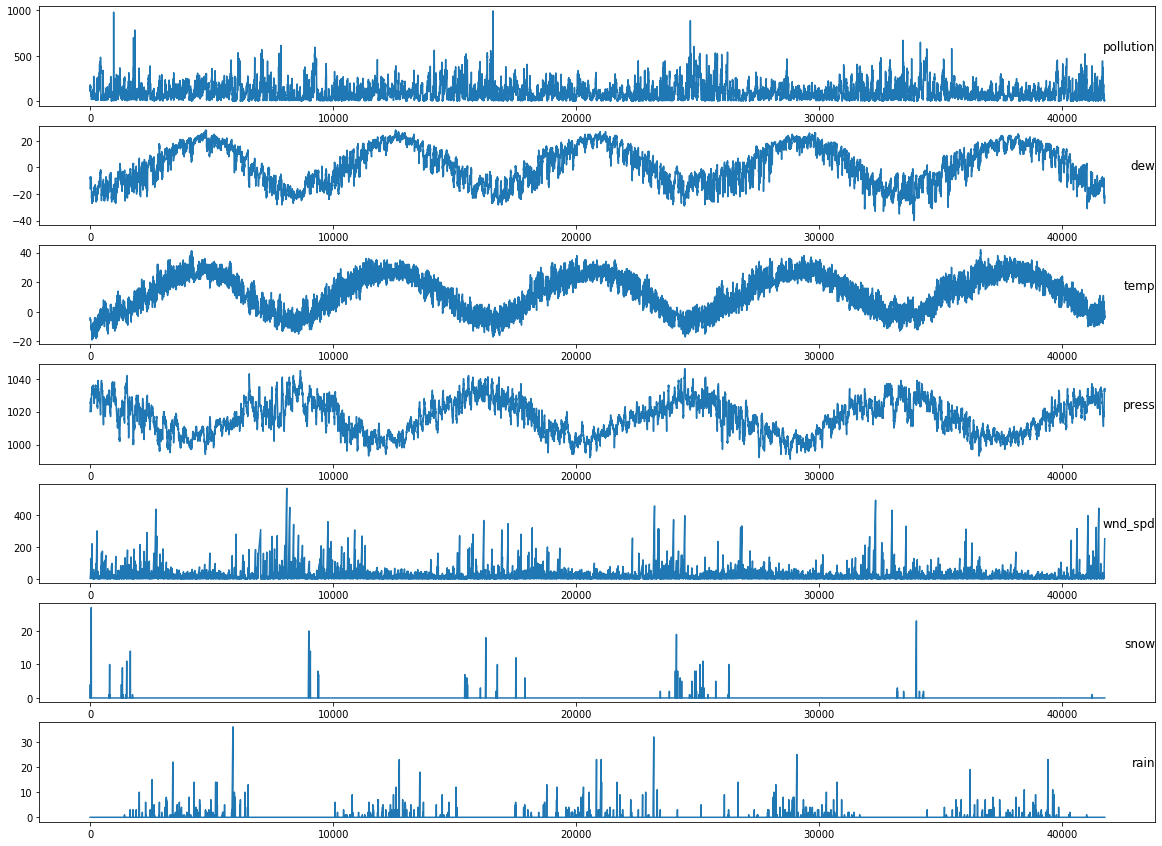

In [10]:
dataset = pd.read_csv('Pollution.csv', header = 0, index_col = 0)
values = dataset.values
groups = [0,1,2,3,5,6,7]
i = 1
plt.figure(figsize=(20,15))
for group in groups:
    plt.subplot(len(groups),1,i)
    plt.plot(values[:,group])
    plt.title(dataset.columns[group],y = 0.5, loc = 'right')
    i+=1
plt.show()
    

In [11]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [25]:
def supervised_to_timeseries(data,n_in = 1,n_out = 0):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    names = []
    # for input X (t-1)
    cols.append(df.shift(n_in))
    names += [('var%d(t-1)' % (j+1)) for j in range(n_vars)]
    
    # for target Y (t)
    cols.append(df.shift(-n_out))
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    
    agg = pd.concat(cols,axis = 1)
    agg.columns = names
    
    #drop NaN
    agg.dropna(inplace = True)
    return agg


In [27]:
encoder = LabelEncoder()
values = dataset.values
values[:,4] = encoder.fit_transform(values[:,4])

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

df = supervised_to_timeseries(scaled,1,0)
df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005522,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005522,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008690,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008690,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.010265,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.010265,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011840,0.111111,0.0


In [28]:
#drop columns we dont need
df.drop(df.columns[[9,10,11,12,13,14,15]],axis = 1,inplace = True)
df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005522,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008690,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.010265,0.074074,0.0,0.109658


In [38]:
X = df.drop(df.columns[[-1]],axis = 1)
y = df['var1(t)']

In [181]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [182]:
#LSTM model takes 3D input 

X_train = X_train.values #reshape doesnt work with dataframe
X_test = X_test.values
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))


In [142]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(33404, 1, 8) (33404,) (8352, 1, 8) (8352,)



Train on 33404 samples, validate on 8352 samples
Epoch 1/50
 - 7s - loss: 0.0230 - val_loss: 0.0147
Epoch 2/50
 - 4s - loss: 0.0133 - val_loss: 0.0140
Epoch 3/50
 - 2s - loss: 0.0132 - val_loss: 0.0140
Epoch 4/50
 - 2s - loss: 0.0132 - val_loss: 0.0139
Epoch 5/50
 - 4s - loss: 0.0132 - val_loss: 0.0135
Epoch 6/50
 - 5s - loss: 0.0131 - val_loss: 0.0138
Epoch 7/50
 - 4s - loss: 0.0131 - val_loss: 0.0136
Epoch 8/50
 - 4s - loss: 0.0131 - val_loss: 0.0137
Epoch 9/50
 - 4s - loss: 0.0131 - val_loss: 0.0135
Epoch 10/50
 - 4s - loss: 0.0131 - val_loss: 0.0135
Epoch 11/50
 - 4s - loss: 0.0131 - val_loss: 0.0133
Epoch 12/50
 - 4s - loss: 0.0131 - val_loss: 0.0132
Epoch 13/50
 - 4s - loss: 0.0131 - val_loss: 0.0133
Epoch 14/50
 - 4s - loss: 0.0131 - val_loss: 0.0132
Epoch 15/50
 - 4s - loss: 0.0131 - val_loss: 0.0132
Epoch 16/50
 - 4s - loss: 0.0131 - val_loss: 0.0132
Epoch 17/50
 - 4s - loss: 0.0131 - val_loss: 0.0132
Epoch 18/50
 - 4s - loss: 0.0131 - val_loss: 0.0131
Epoch 19/50
 - 4s - los

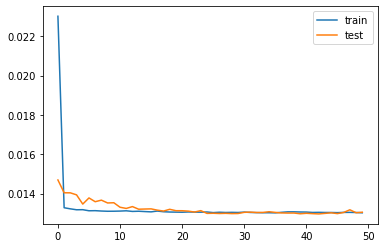

In [54]:
#design network
model = Sequential()
model.add(LSTM(50, input_shape = (X_train.shape[1],X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam')

#fit network
Model = model.fit(X_train,y_train, epochs = 50, batch_size = 72, validation_data = (X_test,y_test), verbose = 2, shuffle = False)

#plot history
plt.plot(Model.history['loss'], label = 'train')
plt.plot(Model.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [183]:
#make prediction
yhat = model.predict(X_test)

#inverse X_test for actual y (since inverse only applies on dimension used for scaling)
X_test = X_test.reshape((X_test.shape[0],X_test.shape[2])) #from 3D to 2D

y_test = y_test.values.reshape(len(y_test),1) #since pd.concat works with
test = np.concatenate((y_test, X_test[:,1:]), axis = 1)
inv_test = scaler.inverse_transform(test)
inv_y = inv_test[:,0]

#inverse for actual yhat
test = np.concatenate((yhat, X_test[:,1:]), axis = 1)
inv_test = scaler.inverse_transform(test)
inv_yhat = inv_test[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 24.669


In [180]:
"""ALTERNATIVE"""


#make prediction
yhat = model.predict(X_test)

#inverse X_test for actual y (since inverse only applies on dimension used for scaling)
X_test = X_test.reshape((X_test.shape[0],X_test.shape[2]))
X_test = pd.DataFrame(X_test) #cannot concat 2 arrays with pandas concat
test = pd.concat((y_test, X_test.iloc[:,1:]), axis = 1)
inv_test = scaler.inverse_transform(test)
inv_y = inv_test[:,0]

#inverse for actual yhat
yhat = yhat.reshape((yhat.shape[0],1))
yhat = pd.Series(yhat)
test = pd.concat((yhat, X_test.iloc[:,1:]), axis = 1)
inv_test = scaler.inverse_transform(test)
inv_yhat = inv_test[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)



Exception: Data must be 1-dimensional

(8352, 1)